### Aggregation and Visualization at patch level

In [1]:
import xarray as xr
from pycocotools.coco import COCO
import netCDF4
from pathlib import Path
import numpy as np
import pandas as pd

from utils.config import BANDS, REFERENCE_BAND, NORMALIZATION_DIV

In [2]:
# Load netcdf (lazy load), request specific band to load in memory
# Each patch is self-described
patch = netCDF4.Dataset(Path('data/patches/2020_31TCG_patch_14_14.nc'), 'r')
patch

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2020_31TCG_patch_14_14
    patch_year: 2020
    patch_name: patch_14_14
    patch_country_code: ES
    patch_tile: 31TCG
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

In [3]:
# Example: load band 2
band_data = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02']))
band_data

<xarray.Dataset>
Dimensions:  (time: 43, x: 366, y: 366)
Coordinates:
    band     int64 ...
  * y        (y) float64 4.649e+06 4.649e+06 4.649e+06 ... 4.645e+06 4.645e+06
  * x        (x) float64 3.512e+05 3.513e+05 3.513e+05 ... 3.549e+05 3.549e+05
  * time     (time) datetime64[ns] 2020-01-08T10:44:21 ... 2020-11-18T10:43:29
Data variables:
    B02      (time, y, x) uint16 ...

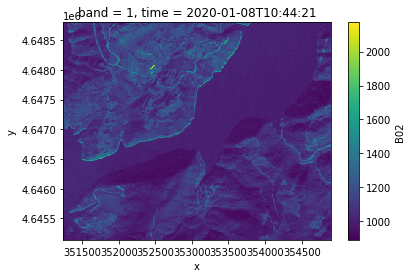

In [4]:
# Plot first sample (t0)
band_data.B02.isel(time=0).plot()

Plot labels

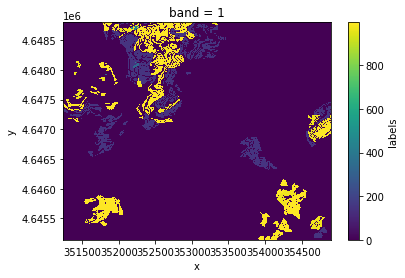

In [5]:
# Example: load labels
labels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
labels.labels.plot()

Plot Parcels

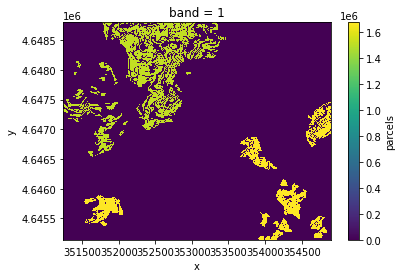

In [6]:
# Example: load parcels
parcels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels']))
parcels.parcels.plot()

In [7]:
# Or maybe aggregate based on a given frequency
# Refer to
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
group_freq = '1MS'

# Grab year from netcdf4's global attribute
year = patch.patch_year

# output intervals
date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)
date_range

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [8]:
# Aggregate based on given frequency
band_data = band_data.groupby_bins(
    'time',
    bins=date_range,
    right=True,
    include_lowest=False,
    labels=date_range[:-1]
).median(dim='time')

band_data

<xarray.Dataset>
Dimensions:    (time_bins: 12, x: 366, y: 366)
Coordinates:
  * time_bins  (time_bins) datetime64[ns] 2020-01-01 2020-02-01 ... 2020-12-01
    band       int64 1
  * y          (y) float64 4.649e+06 4.649e+06 4.649e+06 ... 4.645e+06 4.645e+06
  * x          (x) float64 3.512e+05 3.513e+05 3.513e+05 ... 3.549e+05 3.549e+05
Data variables:
    B02        (time_bins, y, x) float64 1e+03 990.0 994.0 995.5 ... nan nan nan

#### Based on given frequency (i.e monthly), empty instances might appear

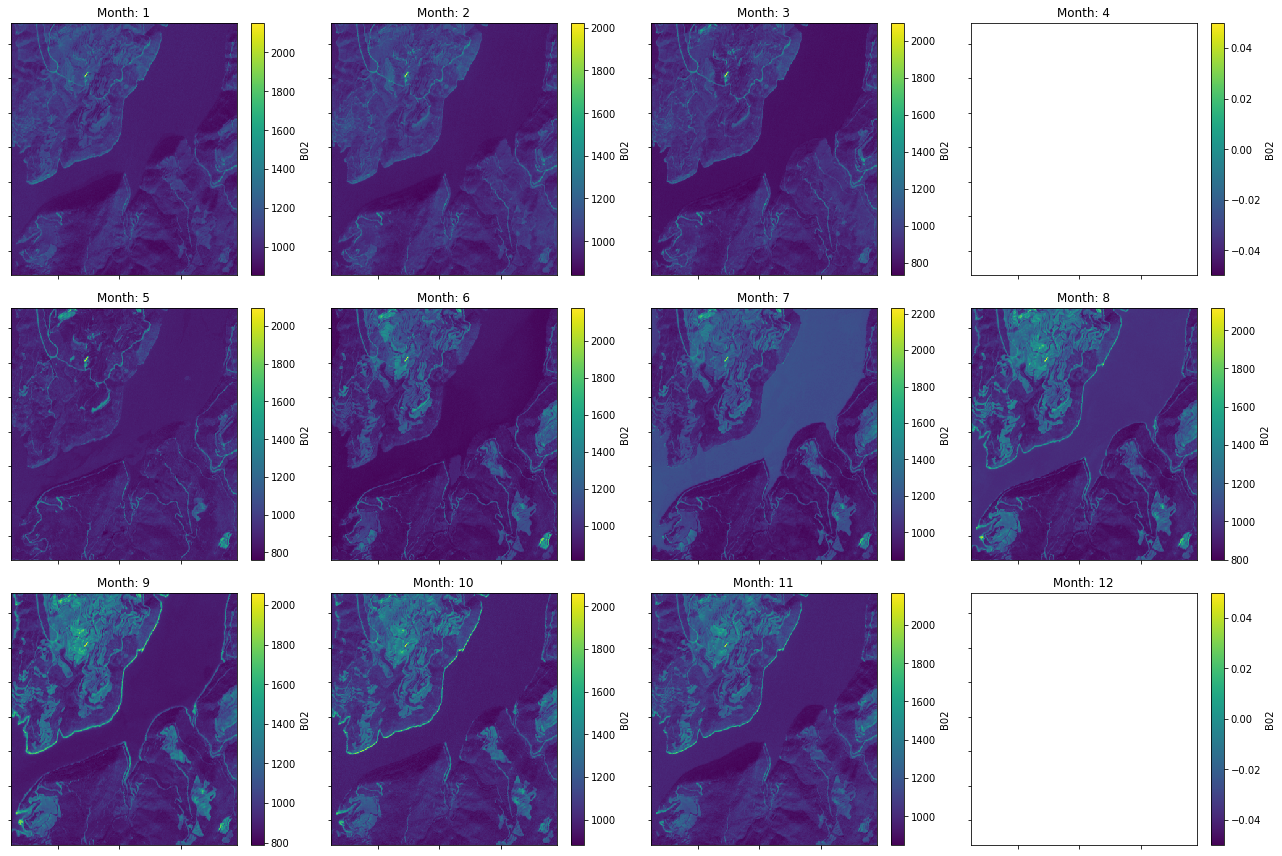

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i, season in enumerate(band_data.B02):
    
    ax = axes.flat[i]
    cax = band_data.B02.isel(time_bins=i).plot(ax=ax)
    

for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Month: {i+1}')
    

plt.tight_layout()
plt.show()

####  This can be solved by using interpolation

In [10]:
band_data = band_data.interpolate_na(dim='time_bins', method='linear')

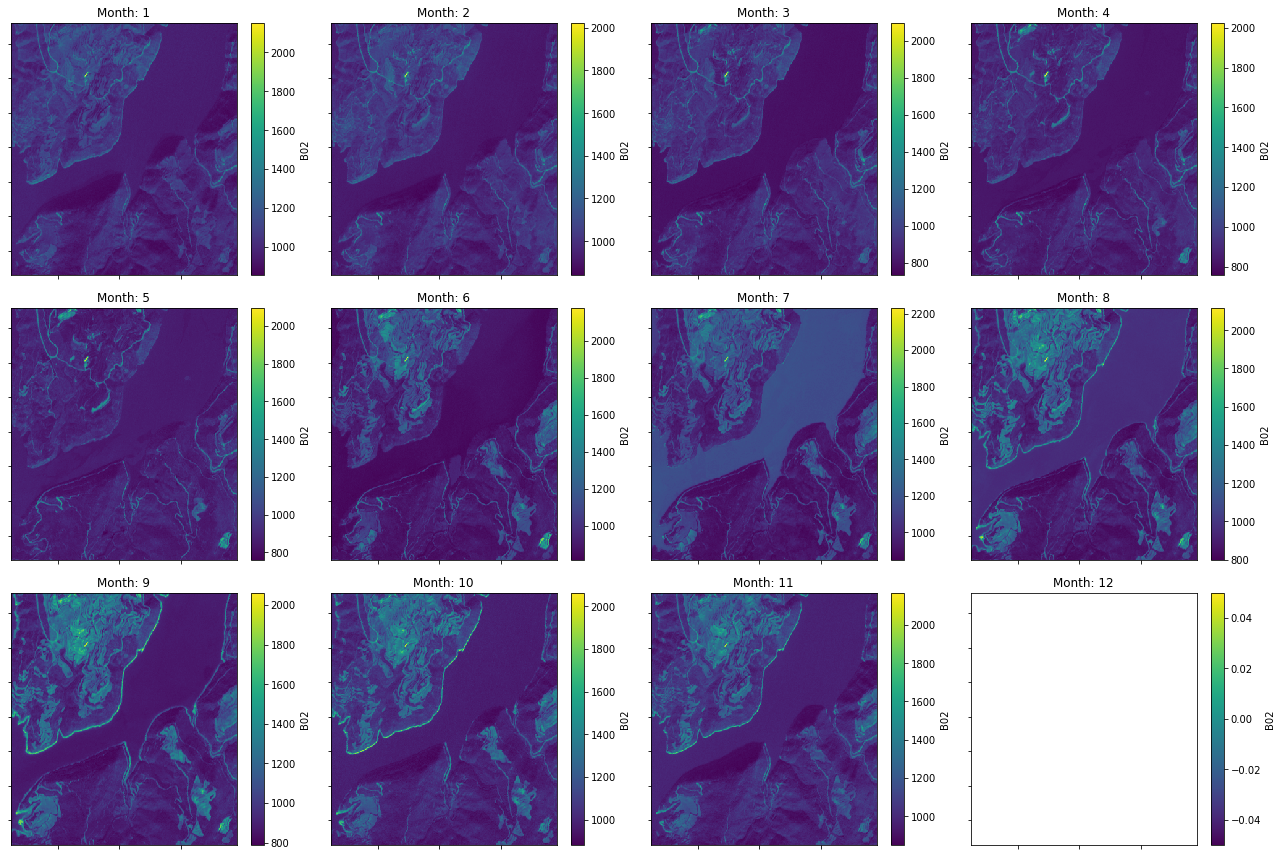

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i, season in enumerate(band_data.B02):
    
    ax = axes.flat[i]
    cax = band_data.B02.isel(time_bins=i).plot(ax=ax)
    

for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Month: {i+1}')
    

plt.tight_layout()
plt.show()

#### Leading or Trailing months are still, empty. To solve this, use extrapolate as fill value.

In [12]:
band_data = band_data.interpolate_na(dim='time_bins', method='linear', fill_value='extrapolate')

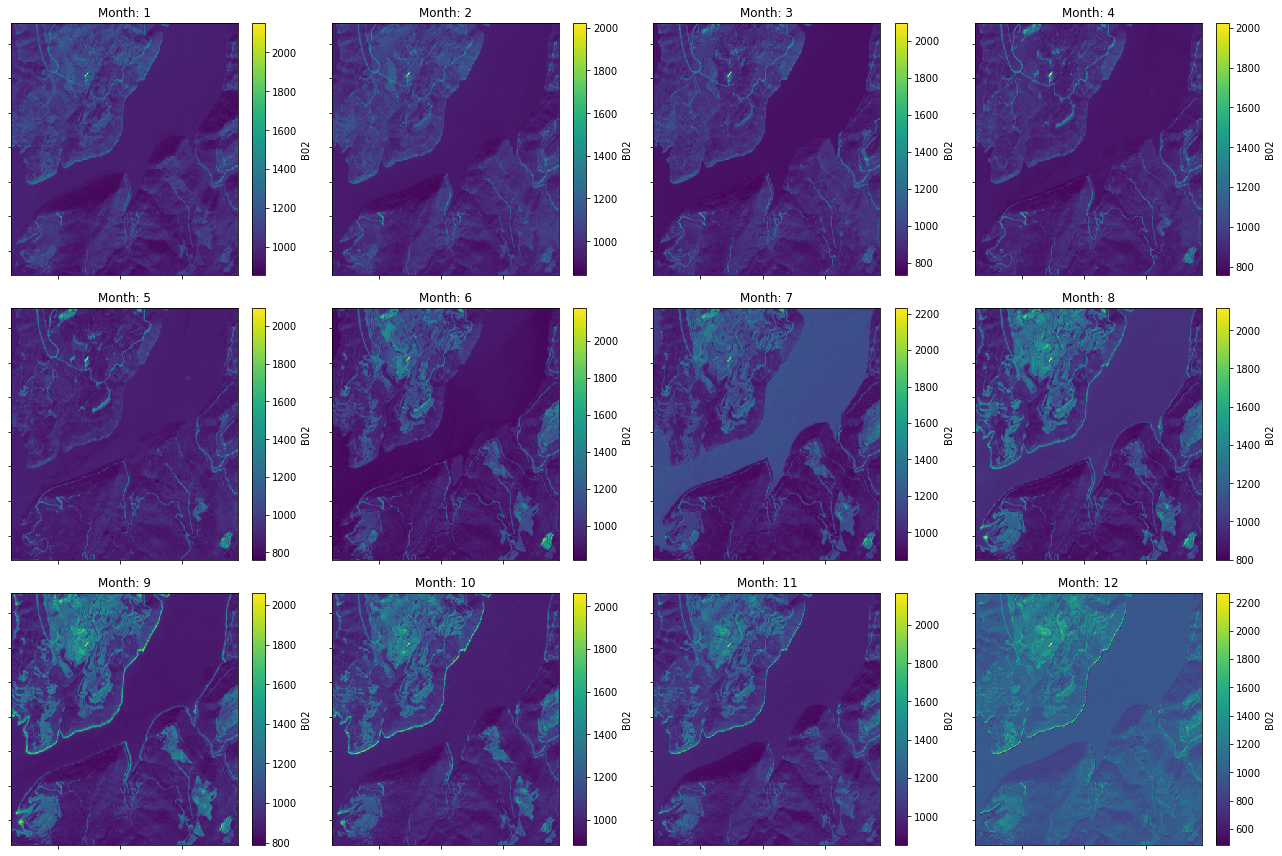

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))

for i, season in enumerate(band_data.B02):
    
    ax = axes.flat[i]
    cax = band_data.B02.isel(time_bins=i).plot(ax=ax)
    

for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Month: {i+1}')
    

plt.tight_layout()
plt.show()

#### Putting everything together (loading all bands)

In [14]:
# Aggregating Frequency
group_freq = '2MS'

# Grab year from netcdf4's global attribute
year = patch.patch_year
print(year)

# output intervals
date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)
print(date_range)

# all bands
band_names = sorted(BANDS.keys())
print(band_names)

# Size of patch
img_size = 366

# out, aggregated array
out = np.empty((len(band_names), len(date_range)-1, img_size, img_size), dtype=np.float32)
print(out.shape)

2020
DatetimeIndex(['2020-01-01', '2020-03-01', '2020-05-01', '2020-07-01',
               '2020-09-01', '2020-11-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='2MS')
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A']
(13, 6, 366, 366)


In [15]:
for band_id, band in enumerate(band_names):

    # Load band data
    band_data = xr.open_dataset(xr.backends.NetCDF4DataStore(patch[band]))
                                
    # Aggregate into time bins
    band_data = band_data.groupby_bins(
        'time',
        bins=date_range,
        right=True,
        include_lowest=False,
        labels=date_range[:-1]
    ).median(dim='time')
             
    # Upsample so months without data are initiated with NaN values
    band_data = band_data.resample(time_bins=group_freq).median(dim='time_bins')
                                                                     
    # Fill:
    # NaN months with linear interpolation
    # NaN months outsize of range (e.x month 12) using extrapolation
    band_data = band_data.interpolate_na(dim='time_bins', method='linear', fill_value='extrapolate')
                               
    # Convert to numpy array
    band_data = band_data[f'{band}'].values
                               
    # If expand ratio is 1, that means current band has the same resolution as reference band
    expand_ratio = int(BANDS[band] / BANDS[REFERENCE_BAND])
                       
    # If resolution does not match reference band, stretch it
    if expand_ratio != 1:
        band_data = np.repeat(band_data, expand_ratio, axis=1)
        band_data = np.repeat(band_data, expand_ratio, axis=2)
                              
    out[band_id, :, :, :] = np.expand_dims(band_data, axis=0)
                                               
# Reshape so window length is first
out = out.transpose(1, 0, 2, 3)

In [16]:
out.shape

(6, 13, 366, 366)

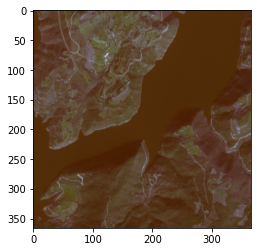

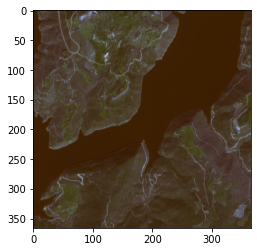

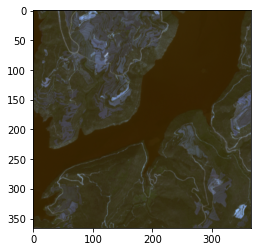

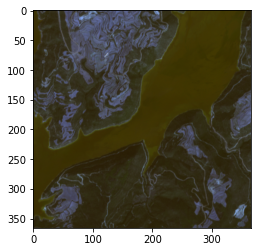

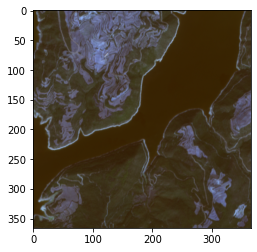

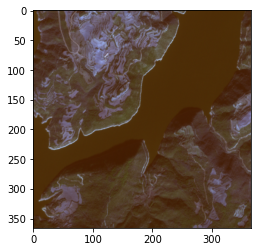

In [17]:
# Visualize, (first time bin, channels 2, 3, 4)

for time_bin in range(len(date_range)-1):
    img = out[time_bin, 1:4, :, :].transpose(1, 2, 0)

    # Using current max, min for normalizing from [0, 1k] -> [0, 1]
    # cause dividing by 1k, makes the image dark
    img = (img - img.min()) * (1 / (img.max() - img.min()))

    plt.imshow(img)
    plt.show()